In [1]:
import math
import numpy as np
import sys
from scipy.spatial.distance import cdist
from scipy.stats import rv_discrete
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import datasets
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib.animation import FuncAnimation
import random
import cv2
from skimage.color import rgb2lab



In [2]:
def load_points(filename):
    data = np.genfromtxt(filename, delimiter=',')
    return data
def collapse_clusters(clusters,threshold):
    dist_clusters = cdist(clusters,clusters) <= threshold
    modes = []
    left = [i for i in range(dist_clusters.shape[0])]
    mapping = np.zeros((dist_clusters.shape[0],))
    labels = np.zeros((dist_clusters.shape[0],))
    while len(left)>0:
        i = left[0]
        indexes = np.where(dist_clusters[i] == True)[0]
        if indexes.shape[0] > 1:
            max_ind = indexes[np.argmax(np.linalg.norm(clusters[indexes], axis=1))]
            modes.append(clusters[max_ind])
            mapping[indexes] = max_ind
            labels[indexes] = len(modes) - 1
        else:
            mapping[i] = i
            modes.append(clusters[i])
            labels[i] = len(modes) - 1
        indexes = indexes.tolist()
        left = [j for j in left if j not in indexes]
    modes = np.array(modes)
    return modes, mapping,labels
def cluster_epanechnikov(points, kernel_bandwidth, lambda_=0.001):
    shift_points = np.array(points)
    modes = []
    iteration_number = 0
    r = kernel_bandwidth * kernel_bandwidth
    count = 0
    shifts = []
    for m in range(points.shape[0]):
        z_old = points[m]
        z_new = None
        lambda__= 4.
        #epanechnikov mean shift iterate
        while lambda__ > lambda_:
            iteration_number += 1
            I = np.where(cdist(np.array([z_old]),points, 'sqeuclidean')[0] < r)[0]
            sum_I = np.sum(points[I],axis=0)
            z_new = sum_I/I.shape[0]
            if np.array_equal(z_new,z_old):
                J = np.where(cdist(np.array([z_new]),points, 'sqeuclidean')[0] == r)[0]
                if J.shape[0] == 0:
                    break
                else:
                    x_j = points[random.choice(J.tolist())]
                    z_new = (x_j +sum_I)/(I.shape[0]+1)
                    print('HERE')
            lambda__ = np.linalg.norm(z_new - z_old)
            z_old = z_new
        shifts.append(z_new)
    tmp = np.array(shifts)
    all_modes = np.unique(tmp, axis = 0)
    modes, mapping,labels_ = collapse_clusters(all_modes,kernel_bandwidth)
    labels = np.zeros((points.shape[0],))
    for m in range(points.shape[0]):
        for i in range(all_modes.shape[0]):
            if np.array_equal(all_modes[i],tmp[m]):
                labels[m] = labels_[i]
                break
    return labels, modes,np.unique(labels), modes.shape[0],iteration_number/points.shape[0]

def cluster_epanechnikov_deflation(points, kernel_bandwidth,lambda_=0.001):
    shift_points = np.array(points)
    modes = []
    iteration_number = 0
    r = kernel_bandwidth * kernel_bandwidth
    count = 0
    shifts = np.zeros(points.shape)
    M = [i for i in range(points.shape[0])]
    while len(M) > 0:
        m = random.choice(M)
        z_old = points[m]
        z_new = None
        lambda__= 4.
        #epanechnikov mean shift iterate
        I = []
        while lambda__ > lambda_:
            iteration_number += 1
            I = np.where(cdist(np.array([z_old]),points, 'sqeuclidean')[0] < r)[0]
            sum_I = np.sum(points[I],axis=0)
            z_new = sum_I/I.shape[0]
            if np.array_equal(z_new,z_old):
                J = np.where(cdist(np.array([z_new]),points, 'sqeuclidean')[0] == r)[0]
                if J.shape[0] == 0:
                    break
                else:
                    j = random.choice(J.tolist())
                    x_j = points[j]
                    z_new = (x_j +sum_I)/(I.shape[0]+1)
                    I = I.tolist()
                    I.append(j)
                    I = np.array(I)
            lambda__ = np.linalg.norm(z_new - z_old)
            z_old = z_new
        I = I.tolist()
        M = [l for l in M if l not in I and l != m]
        shifts[m] = z_new
        shifts[I] = z_new
    all_modes = np.unique(shifts, axis = 0)
    modes, mapping,labels_ = collapse_clusters(all_modes,kernel_bandwidth)
    labels = np.zeros((points.shape[0],))
    
    for m in range(points.shape[0]):
        for i in range(all_modes.shape[0]):
            if np.array_equal(all_modes[i],shifts[m]):
                labels[m] = labels_[i]
                break
    return labels, modes,np.unique(labels), modes.shape[0],iteration_number/points.shape[0]


def plot2D(X,Y,labels,n_clusters_,cluster_centers):
    # #############################################################################

    print("number of estimated clusters : %d" % n_clusters_)

    # #############################################################################
    # Plot result
    plt.figure(1)
    plt.clf()

    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        my_members = Y == k
        cluster_center = cluster_centers[k]
        plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
def plot3D(X,Y,labels,n_clusters_,cluster_centers):
    # #############################################################################

    print("number of estimated clusters : %d" % n_clusters_)

    # #############################################################################
    # Plot result
    ax = plt.axes(projection='3d')
    fig = plt.figure(1)
    #plt.clf()

    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        my_members = Y == k
        cluster_center = cluster_centers[k]
        
        ax.scatter3D(X[my_members, 0], X[my_members, 1],X[my_members, 2],  c=col)
        ax.scatter3D(cluster_center[0], cluster_center[1],cluster_center[2], c=col, marker='o', edgecolor='k',s=25)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    #fig.show()

# Test our code

## 2D Data

Generate 5000 samples equally distributed among 3 clusters from a normal distribution with std = 0.6 and centroids [[1, 1], [-1, -1], [1, -1]]

In [3]:
# Data and bandwidth
#X = load_points("data.csv")
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=5000, centers=centers, cluster_std=0.6)
#X,y = datasets.make_circles(n_samples=1500, factor=.5,noise=.05)#datasets.make_moons(n_samples=1500, noise=.05)
kernel_bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

In [4]:
X.shape,kernel_bandwidth

((5000, 2), 1.008952724437039)

### Our implementation

average iteration per point : 11.313200
number of estimated clusters : 3


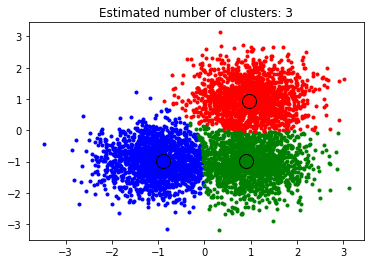

In [5]:
labels,cluster_centers,labels_unique,n_clusters_,avg_iterates = cluster_epanechnikov(X, kernel_bandwidth=kernel_bandwidth)
print("average iteration per point : %f" % avg_iterates)
plot2D(X,labels,labels_unique,n_clusters_,cluster_centers)

In [6]:
cluster_centers

array([[-0.90420694, -0.99176301],
       [ 0.89376463, -0.97386956],
       [ 0.97099362,  0.92094727]])

***Epanechnikov Mean Shift deflation***

Comparison with the non deflation

average iteration per point : 2.516600
number of estimated clusters : 3


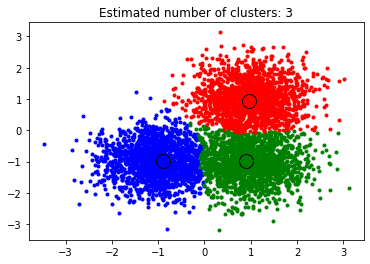

In [7]:
labels,cluster_centers,labels_unique,n_clusters_,avg_iterates = cluster_epanechnikov_deflation(X, kernel_bandwidth=kernel_bandwidth)
print("average iteration per point : %f" % avg_iterates)
plot2D(X,labels,labels_unique,n_clusters_,cluster_centers)

For this experiments we generate tot_clusters clusters from a normal distribution with std as a variable, and we want to evaluate the ability of the model to find the correct clusters using the deflation version of the Epanechnikov algorithm: the more seperated are the clusters, the more it will be accurate

Number of true clusters : 6


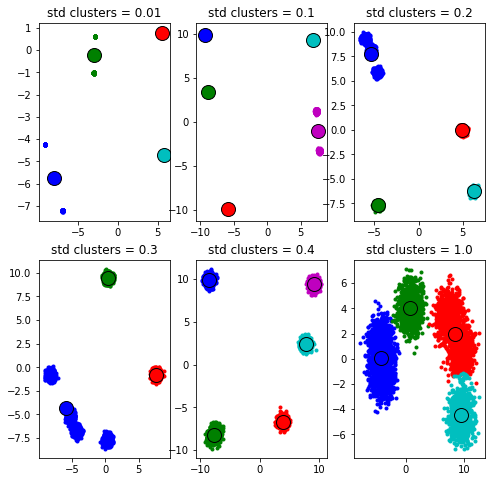

In [8]:
stds = [0.01,0.1,0.2,.3,.4,1.,2.]
cols = int(len(stds)/2)
rows = int(len(stds)/cols)
fig, axs = plt.subplots(ncols=cols, nrows=rows,figsize=(8,8))
tot_clusters = 6
print("Number of true clusters : %d" % tot_clusters)
for i in range(rows):
    for j in range(cols):
        std = stds[i*cols+j]
        X_def, y_true,centers_def= make_blobs(n_samples=tot_clusters*1000, n_features=2, centers=tot_clusters, cluster_std=std,return_centers=True)
        kernel_bandwidth_def = estimate_bandwidth(X_def, quantile=0.2, n_samples=100)
        labels,cluster_centers,labels_unique,n_clusters_,avg_iterates = cluster_epanechnikov_deflation(X_def, kernel_bandwidth=kernel_bandwidth_def)
        axs[i,j].set_title( "std clusters = "+str(std))
        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        for k, col in zip(range(n_clusters_), colors):
            my_members = labels == k
            cluster_center = cluster_centers[k]
            axs[i,j].plot(X_def[my_members, 0], X_def[my_members, 1], col + '.')
            axs[i,j].plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
plt.show()

**Bandwidth influence (Ball radius)**

In this experiment we want to evaluate the influence of the bandwidth on the accuracy of the model: Bigger bandidths lead to less clusters

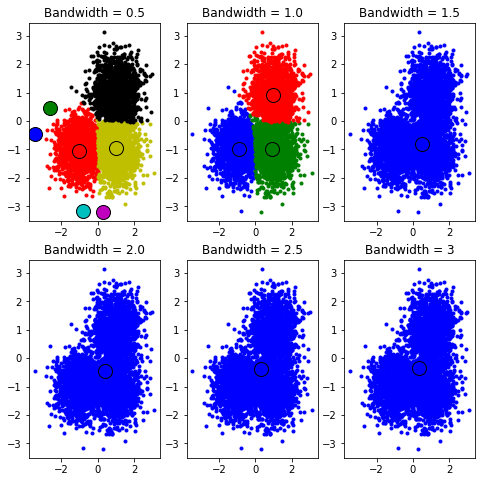

In [9]:
bandwidths = [0.5,1.,1.5,2.,2.5,3]
cols = int(len(bandwidths)/2)
rows = int(len(bandwidths)/cols)
fig, axs = plt.subplots(ncols=cols, nrows=rows,figsize=(8,8))
for i in range(rows):
    for j in range(cols):
        bandwidth = bandwidths[i*cols+j]
        labels,cluster_centers,labels_unique,n_clusters_,avg_iterates = cluster_epanechnikov(X, kernel_bandwidth=bandwidth)
        axs[i,j].set_title( "Bandwidth = "+str(bandwidth))
        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        for k, col in zip(range(n_clusters_), colors):
            my_members = labels == k
            cluster_center = cluster_centers[k]
            axs[i,j].plot(X[my_members, 0], X[my_members, 1], col + '.')
            axs[i,j].plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
plt.show()

**Lambda and iterations**

We want to see how many iterations we get when we change the value of the parameters $ 0 < \lambda \leq ||z^(t-1) - z^t ||^2 $

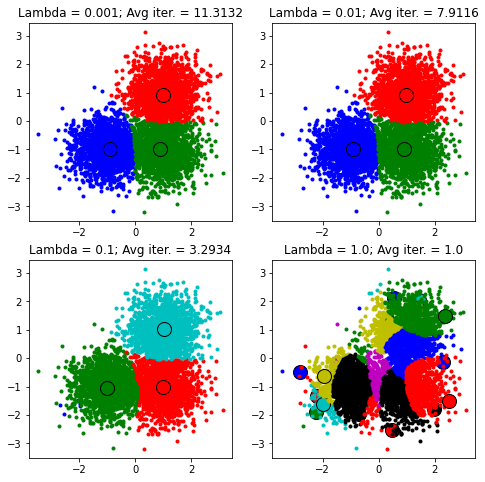

In [10]:
lambdas = [0.001,0.01,0.1,1.]
cols = int(len(lambdas)/2)
rows = int(len(lambdas)/cols)
fig, axs = plt.subplots(ncols=cols, nrows=rows,figsize=(8,8))
for i in range(rows):
    for j in range(cols):
        lambda_ = lambdas[i*cols+j]
        labels,cluster_centers,labels_unique,n_clusters_,avg_iterates = cluster_epanechnikov(X, kernel_bandwidth=kernel_bandwidth,lambda_=lambda_)
        axs[i,j].set_title( "Lambda = "+str(lambda_)+'; Avg iter. = '+str(avg_iterates))
        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        for k, col in zip(range(n_clusters_), colors):
            my_members = labels == k
            cluster_center = cluster_centers[k]
            axs[i,j].plot(X[my_members, 0], X[my_members, 1], col + '.')
            axs[i,j].plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
plt.show()

#### Compare with Scikit-learn

number of estimated clusters : 3


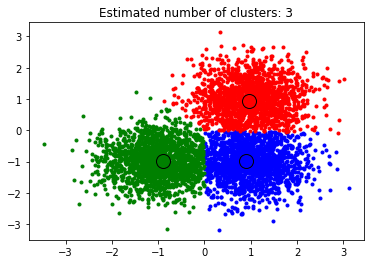

In [11]:
ms = MeanShift(bandwidth=kernel_bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
plot2D(X,labels,labels_unique,n_clusters_,cluster_centers)

In [12]:
cluster_centers

array([[ 0.89318541, -0.96908911],
       [-0.90500608, -0.98971138],
       [ 0.97099362,  0.92094727]])

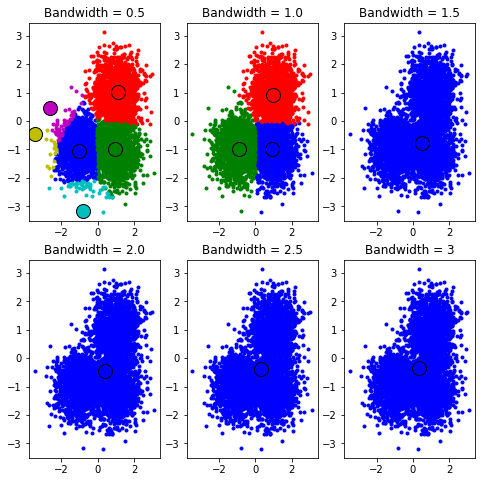

In [13]:

bandwidths = [0.5,1.,1.5,2.,2.5,3]
cols = int(len(bandwidths)/2)
rows = int(len(bandwidths)/cols)
fig, axs = plt.subplots(ncols=cols, nrows=rows,figsize=(8,8))
for i in range(rows):
    for j in range(cols):
        bandwidth = bandwidths[i*cols+j]
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(X)
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_
        labels_unique = np.unique(labels)
        n_clusters_ = len(labels_unique)
        axs[i,j].set_title( "Bandwidth = "+str(bandwidth))
        colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
        for k, col in zip(range(n_clusters_), colors):
            my_members = labels == k
            cluster_center = cluster_centers[k]
            axs[i,j].plot(X[my_members, 0], X[my_members, 1], col + '.')
            axs[i,j].plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
plt.show()

## 3D Data

In [14]:
#X = datasets.load_iris().data
X, _,centers = make_blobs(n_samples=8000, n_features=3, cluster_std=.6,return_centers=True)
kernel_bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

**Our implementation**

average iteration per point : 6.415750
number of estimated clusters : 3


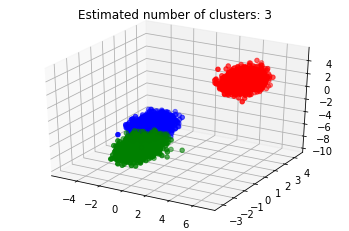

In [15]:
labels,cluster_centers,labels_unique,n_clusters_,avg_iterates = cluster_epanechnikov(X, kernel_bandwidth=kernel_bandwidth)
print("average iteration per point : %f" % avg_iterates)
plot3D(X,labels,labels_unique,n_clusters_,cluster_centers)

In [16]:
cluster_centers,centers

(array([[-3.31320291,  2.3607907 , -7.70651174],
        [-0.94518739, -1.16427997, -6.78098637],
        [ 4.95886138,  1.87156234,  2.75718823]]),
 array([[-0.93944838, -1.1548211 , -6.78096061],
        [ 4.97530616,  1.87064669,  2.76762331],
        [-3.28735451,  2.36971421, -7.71500398]]))

**Compare with Scikit**

number of estimated clusters : 3


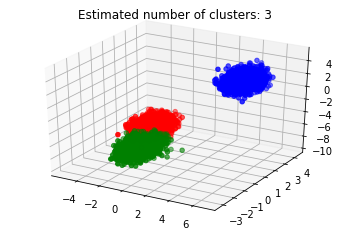

In [17]:
ms = MeanShift(bandwidth=kernel_bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
plot3D(X,labels,labels_unique,n_clusters_,cluster_centers)

In [18]:
cluster_centers,centers

(array([[ 4.95931789,  1.87171651,  2.75557684],
        [-0.9447663 , -1.16407374, -6.78049098],
        [-3.31270574,  2.36183319, -7.70615279]]),
 array([[-0.93944838, -1.1548211 , -6.78096061],
        [ 4.97530616,  1.87064669,  2.76762331],
        [-3.28735451,  2.36971421, -7.71500398]]))

## Image segmentation

In [19]:
img = cv2.imread('bell_peppers.jpg')
originShape = img.shape
colors_img = np.reshape(img, [-1, 3])
kernel_bandwidth = estimate_bandwidth(colors_img, quantile=0.1, n_samples=100)
kernel_bandwidth,colors_img.shape

(42.40246824914022, (5544, 3))

average iteration per point : 15.453824
number of estimated clusters : 12


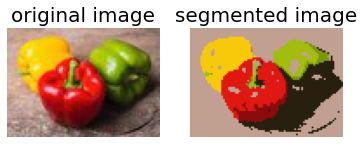

In [20]:
labels,cluster_centers,labels_unique,n_clusters_,avg_iterates = cluster_epanechnikov(colors_img, kernel_bandwidth=kernel_bandwidth)
print("average iteration per point : %f" % avg_iterates)
print("number of estimated clusters : %d" % n_clusters_)
segmented = cluster_centers[np.reshape(np.array(labels), originShape[:2]).astype(np.uint8)].astype(np.uint8)
plt.figure()
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.title('original image', size=20)
plt.subplot(122)
plt.imshow(segmented[:,:,::-1])
plt.axis('off')
plt.title('segmented image', size=20)
plt.show()

number of estimated clusters : 7


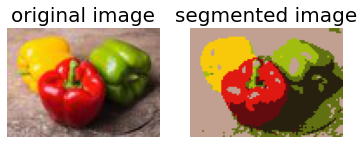

In [21]:
ms = MeanShift(bandwidth = kernel_bandwidth, bin_seeding=True)
ms.fit(colors_img)
labels=ms.labels_
cluster_centers = ms.cluster_centers_    
labels_unique = np.unique(labels)    
n_clusters_ = len(labels_unique)    
print("number of estimated clusters : %d" % n_clusters_)
segmented = cluster_centers[np.reshape(labels, originShape[:2])].astype(np.uint8)
plt.figure()
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.title('original image', size=20)
plt.subplot(122)
plt.imshow(segmented[:,:,::-1])
plt.axis('off')
plt.title('segmented image', size=20)
plt.show()